<a href="https://colab.research.google.com/drive/1dQJxbVKndhaqJAclIhNa0Q6zWLdxh-pK#scrollTo=IY0ZcoMdykZP" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import tarfile
import shutil
import random

import pandas as pd
import numpy as np

import torch
from torchvision import models
import torch.optim as optim
from torchvision.datasets.utils import download_url
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Функция для установки детерменистичности

def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch()

In [3]:
# Загрузка датасета

dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-320.tgz"
download_url(dataset_url, '.')

# Разархивируем данные

with tarfile.open('./imagewoof2-320.tgz', 'r:gz') as tar: 
  tar.extractall(path = './data')

  0%|          | 0/328387740 [00:00<?, ?it/s]

In [4]:
data_dir = './data/imagewoof2-320'

print(os.listdir(data_dir))

['train', 'noisy_imagewoof.csv', 'val']


In [5]:
print(os.listdir('./data/imagewoof2-320/train'))
print("Количество папок: ", len(os.listdir('./data/imagewoof2-320/train')))

['n02086240', 'n02093754', 'n02088364', 'n02089973', 'n02105641', 'n02096294', 'n02111889', 'n02087394', 'n02099601', 'n02115641']
Количество папок:  10


In [6]:
# Классы картинок

classes = ['Shih-Tzu', 'Rhodesian ridgeback', 'Beagle', 'English foxhound', 
           'Border terrier', 'Australian terrier', 'Golden retriever', 
           'Old English sheepdog', 'Samoyed', 'Dingo']
print("Всего классов: ", len(classes))

Всего классов:  10


In [7]:
train_directory = './data/imagewoof2-320/train'

for root, dirs, files in os.walk(train_directory):
  if files == []:
    continue
  else:
    print(len(files))

941
949
932
580
928
943
921
942
949
940


In [8]:
test_directory = './data/imagewoof2-320/val'

for root, dirs, files in os.walk(test_directory):
  if files == []:
    continue
  else:
    print(len(files))

409
401
418
224
422
407
429
408
401
410


In [9]:
df_labels = pd.read_csv(os.path.join(data_dir, 'noisy_imagewoof.csv'))
df_labels.head()

,path,noisy_labels_0,noisy_labels_1,noisy_labels_5,noisy_labels_25,noisy_labels_50,is_valid
0,train/n02115641/n02115641_3995.JPEG,n02115641,n02115641,n02115641,n02115641,n02115641,False
1,train/n02115641/n02115641_843.JPEG,n02115641,n02115641,n02105641,n02115641,n02088364,False
2,train/n02115641/n02115641_2953.JPEG,n02115641,n02115641,n02115641,n02111889,n02099601,False
3,train/n02115641/n02115641_6458.JPEG,n02115641,n02115641,n02115641,n02093754,n02115641,False
4,train/n02115641/n02115641_19414.JPEG,n02115641,n02115641,n02115641,n02115641,n02088364,False


In [10]:
source_dir = './data/modified'

for dirpath, _, _ in os.walk(data_dir):
    structure = os.path.join(source_dir, dirpath[len(data_dir)+1:])
    if not os.path.isdir(structure):
        os.mkdir(structure)

train_dir = os.path.join(source_dir, 'train')
val_dir = os.path.join(source_dir, 'val')
unlabelled_dir = os.path.join(source_dir, 'unlabelled')

if not os.path.isdir(unlabelled_dir):
    os.mkdir(unlabelled_dir)

In [11]:
# Функция для выделения размеченных/неразмеченных картинок

def move_file(row):
    true_label = row['noisy_labels_0'].strip()
    noisy_label = row['noisy_labels_50'].strip()
    path = row['path'].split('/')
    if true_label == noisy_label:
        # Размеченные данные
        shutil.move(os.path.join(data_dir, *path), 
                    os.path.join(source_dir, *path))
    else:
        # Неразмеченные данные
        shutil.move(os.path.join(data_dir, *path), 
                    os.path.join(source_dir, 'unlabelled', path[2]))

df_labels.apply(move_file, axis=1);

Будем считать, что зашумленные на 50% данные не будут участвовать при обучении модели.

In [12]:
total_train = 0
for folder in os.listdir(train_dir):
    total_train += len(os.listdir(os.path.join(train_dir, folder)))
total_unlabelled = len(os.listdir(unlabelled_dir))
print(f"Количество размеченных картинок в тренировочном сете: {total_train}")
print(f"Количество неразмеченных картинок в тренировочном сете: {total_unlabelled}")

Количество размеченных картинок в тренировочном сете: 4512
Количество неразмеченных картинок в тренировочном сете: 4513


In [13]:
# Переводим картинки в тензоры

image_size_test = ImageFolder(train_dir, transforms.ToTensor())

In [14]:
height = []
width = []
for image,_ in image_size_test:
    height.append(image.shape[1])
    width.append(image.shape[2])
print(f"минимальная высота: {min(height)}, максимальная высота: {max(height)}")
print(f"минимальная ширина: {min(width)}, максимальная ширина: {max(width)}")

минимальная высота: 320, максимальная высота: 783
минимальная ширина: 320, максимальная ширина: 747


In [15]:
train_transforms = transforms.Compose([transforms.RandomCrop(320),
                         transforms.RandomHorizontalFlip(p=0.5),
                         transforms.RandomVerticalFlip(p=0.5),
                         transforms.RandomRotation(degrees=30),
                         transforms.ToTensor(),
                         transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                              std=[0.229, 0.224, 0.225])]
                                     )

In [16]:
test_transforms = transforms.Compose([transforms.CenterCrop(320),
                         transforms.ToTensor(),
                         transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                              std=[0.229, 0.224, 0.225])]
                                     )

In [17]:
train_ds = ImageFolder(train_dir, train_transforms)
val_ds = ImageFolder(val_dir, test_transforms)

In [18]:
height = []
width = []
for image,_ in train_ds:
    height.append(image.shape[1])
    width.append(image.shape[2])
print(f"минимальная высота: {min(height)}, максимальная высота: {max(height)}")
print(f"минимальная ширина: {min(width)}, максимальная ширина: {max(width)}")

минимальная высота: 320, максимальная высота: 320
минимальная ширина: 320, максимальная ширина: 320


In [19]:
classes_dict = dict(zip(os.listdir('./data/imagewoof2-320/train'), classes))
print(classes_dict)

{'n02086240': 'Shih-Tzu', 'n02093754': 'Rhodesian ridgeback', 'n02088364': 'Beagle', 'n02089973': 'English foxhound', 'n02105641': 'Border terrier', 'n02096294': 'Australian terrier', 'n02111889': 'Golden retriever', 'n02087394': 'Old English sheepdog', 'n02099601': 'Samoyed', 'n02115641': 'Dingo'}


In [20]:
def show_example(img,label):
    print('Класс: ', classes[label])
    plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Класс:  Shih-Tzu


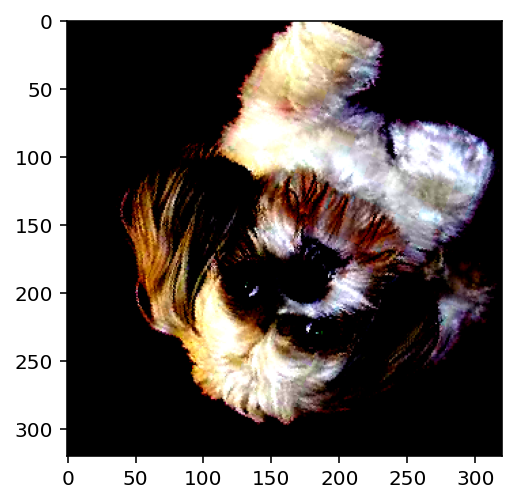

In [21]:
# First image in the train set
show_example(*train_ds[3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Класс:  Beagle


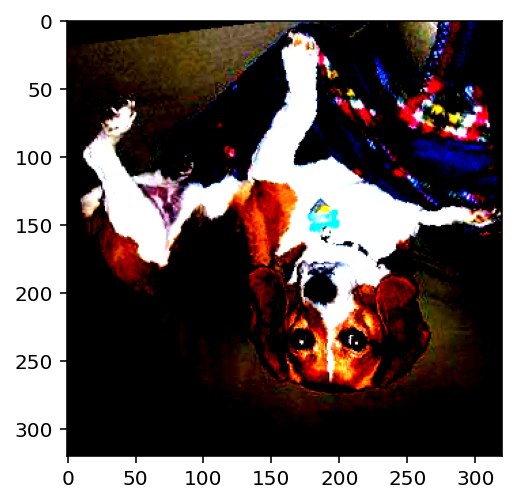

In [22]:
show_example(*train_ds[1000])

In [23]:
batch_size = 16
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers=8, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=8, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [24]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [25]:
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [26]:
# Используем сеть ResNet50 для обучения

model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [27]:
def accuracy(preds, labels):
    preds = torch.argmax(preds, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, criterion, val_loader, best_score):
    model.eval()
    loss, acc = [], []
    for images, labels in val_loader:
        preds = model(images)
        loss.append(criterion(preds, labels).detach())
        acc.append(accuracy(preds, labels))


    return {'val_loss': torch.stack(loss).mean().item(), 
            'val_acc': torch.stack(acc).mean().item()}

In [28]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer):
    history = []
    best_score = 0.
    for epoch in range(epochs):
        model.train()
        train_losses = []
        train_acc = []

        for images, labels in train_loader:
            optimizer.zero_grad()
            preds = model(images)
            loss = criterion(preds, labels)
            train_losses.append(loss)
            train_acc.append(accuracy(preds, labels))
            loss.backward()
            optimizer.step()


        result = evaluate(model, criterion, val_loader, best_score)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_acc).mean().item()
        print("Epoch [{}], train_loss: {:.2f}, train_acc: {:.3f}, val_loss: {:.2f}, val_acc: {:.3f}".format(
            epoch+1, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))
        history.append(result)

        if result['val_acc'] > best_score:
          best_score = result['val_acc']
          torch.save(model.state_dict(), 'imagewoof_ResNet50.pth')
          print("Save best score model!")

    return history

In [29]:
num_epochs = 10

history = fit(num_epochs, model, train_dl, val_dl, criterion, optimizer)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1], train_loss: 1.89, train_acc: 0.486, val_loss: 1.23, val_acc: 0.897
Save best score model!
Epoch [2], train_loss: 1.28, train_acc: 0.765, val_loss: 0.79, val_acc: 0.910
Save best score model!
Epoch [3], train_loss: 0.99, train_acc: 0.797, val_loss: 0.52, val_acc: 0.932
Save best score model!
Epoch [4], train_loss: 0.85, train_acc: 0.817, val_loss: 0.42, val_acc: 0.935
Save best score model!
Epoch [5], train_loss: 0.75, train_acc: 0.829, val_loss: 0.35, val_acc: 0.942
Save best score model!
Epoch [6], train_loss: 0.68, train_acc: 0.832, val_loss: 0.32, val_acc: 0.941
Epoch [7], train_loss: 0.64, train_acc: 0.833, val_loss: 0.28, val_acc: 0.939
Epoch [8], train_loss: 0.61, train_acc: 0.839, val_loss: 0.25, val_acc: 0.946
Save best score model!
Epoch [9], train_loss: 0.59, train_acc: 0.839, val_loss: 0.24, val_acc: 0.944
Epoch [10], train_loss: 0.57, train_acc: 0.840, val_loss: 0.22, val_acc: 0.944


In [30]:
def plot_accuracies(history):
  train_acc = [x.get('train_acc') for x in history]
  val_acc = [x['val_acc'] for x in history]
  plt.plot(train_acc, 'b')
  plt.plot(val_acc, 'r')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend(['Training','Validation'])
  plt.title('Значение Accuracy по эпохам')

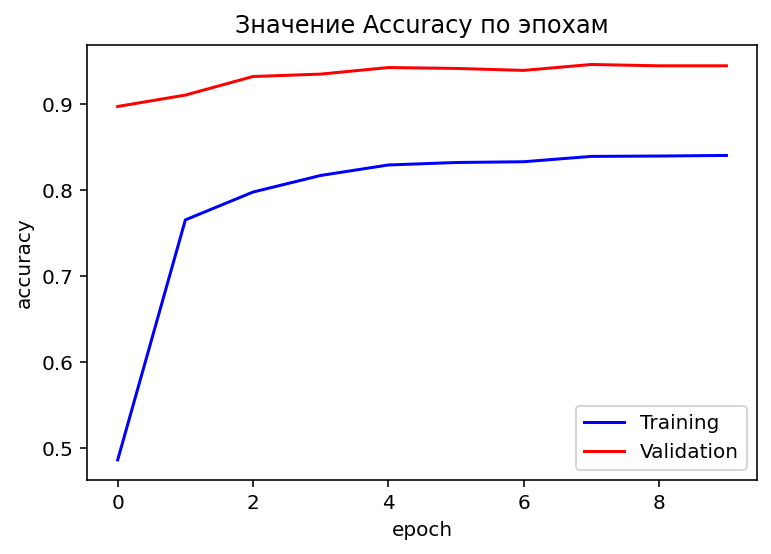

In [34]:
plot_accuracies(history)

In [31]:
def predict_image(img, model):
  xb = to_device(img.unsqueeze(0),device)
  yb = model(xb)
  _, preds = torch.max(yb, dim = 1)
  
  return classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Реальная порода: Shih-Tzu , Предсказание: Shih-Tzu


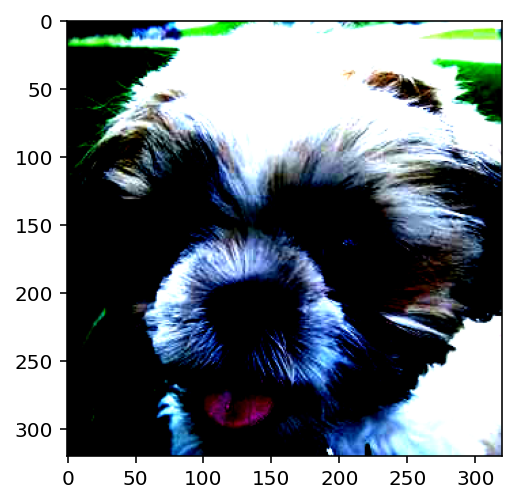

In [32]:
img, label = val_ds[0]
plt.imshow(img.permute(1,2,0))
print("Реальная порода:", classes[label], ', Предсказание:', predict_image(img,model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Реальная порода: Rhodesian ridgeback , Предсказание: Rhodesian ridgeback


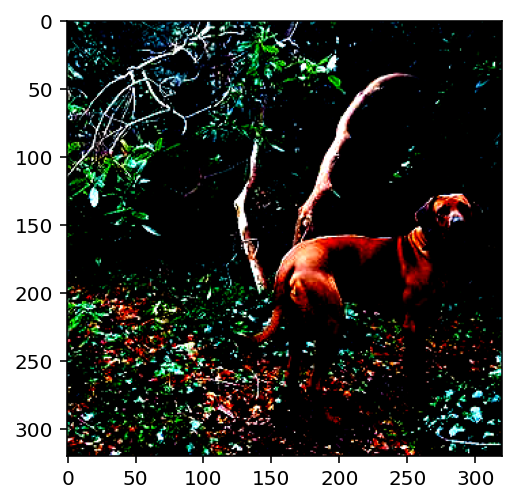

In [33]:
img, label = val_ds[500]
plt.imshow(img.permute(1,2,0))
print("Реальная порода:", classes[label], ', Предсказание:', predict_image(img,model))